# Find Word Embeddings

In [5]:
import os
import pickle
from pathlib import Path

import numpy as np
import torch
from transformers import BertTokenizerFast, BertModel

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
raw_path = "/ocean/projects/mth250011p/shared/215a/final_project/data/raw_text.pkl"

with open(raw_path, "rb") as f:
    raw = pickle.load(f)

print(type(raw))
print(list(raw.keys())[:5])  # story ID

<class 'dict'>
['sweetaspie', 'thatthingonmyarm', 'tildeath', 'indianapolis', 'lawsthatchokecreativity']


In [5]:
# take a look at the second story
ds2 = raw['thatthingonmyarm']
type(ds2)
words2 = ds2.data
len(words2), words2[:20]
text2 = " ".join(words2)
# print(text2)

In [9]:
# load pre-trained BERT
model_name = "bert-base-uncased"

tokenizer = BertTokenizerFast.from_pretrained(model_name)
model = BertModel.from_pretrained(model_name, output_hidden_states=True)
model = model.to(DEVICE)
model.eval()

model

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
  

In [10]:
def get_bert_word_embeddings_for_words(words,
                                       tokenizer,
                                       model,
                                       device=DEVICE,
                                       layer_index=-1,
                                       chunk_size=256):
    """
    Input:
        words: list[str], e.g. ds.data
    Returns:
        embs: np.ndarray, shape (T, 768), where T = len(words)
    Notes:
        - Automatically performs chunking to avoid exceeding BERT's max_length=512
        - Each word’s embedding is computed as the average of its subword embeddings
    """
    T = len(words)
    dim = model.config.hidden_size  # 768
    embs = np.zeros((T, dim), dtype=np.float32)
    counts = np.zeros(T, dtype=np.int32)

    start = 0
    while start < T:
        end = min(start + chunk_size, T)
        chunk_words = words[start:end]

        enc = tokenizer(
            chunk_words,
            is_split_into_words=True,
            return_tensors="pt",
            add_special_tokens=True,
            padding=False,
            truncation=True,
        ).to(device)

        with torch.no_grad():
            out = model(**enc, output_hidden_states=True)
            # Select the specified layer (default = last layer)
            layer = out.hidden_states[layer_index][0].cpu().numpy() 

        # Extract mapping from tokenizer tokens --> original words
        word_ids = enc.word_ids()

        for tok_idx, w_id in enumerate(word_ids):
            if w_id is None:
                continue
            global_w = start + w_id  # Map back to global word index
            if 0 <= global_w < T:
                embs[global_w] += layer[tok_idx]
                counts[global_w] += 1

        start = end

    # Average over subword embeddings for each word
    for i in range(T):
        if counts[i] > 0:
            embs[i] /= counts[i]

    return embs

In [11]:
bert_embeddings = {}  # story_id -> dict

for story_id, ds in raw.items():
    words = ds.data               # list[str]
    word_times = ds.data_times    # np.array, shape (T,)
    tr_times = ds.tr_times        # np.array, shape (n_TR,)

    print(f"Processing story: {story_id}, #words = {len(words)}")

    embs = get_bert_word_embeddings_for_words(
        words=words,
        tokenizer=tokenizer,
        model=model,
        device=DEVICE,
        layer_index=-1,    # last layer
        chunk_size=256
    )  # shape (T, 768)

    print("  embeddings shape:", embs.shape)

    bert_embeddings[story_id] = {
        "words": words,
        "word_times": word_times,
        "tr_times": tr_times,
        "embeddings": embs,
    }

Processing story: sweetaspie, #words = 697
  embeddings shape: (697, 768)
Processing story: thatthingonmyarm, #words = 2073
  embeddings shape: (2073, 768)
Processing story: tildeath, #words = 2297
  embeddings shape: (2297, 768)
Processing story: indianapolis, #words = 1554
  embeddings shape: (1554, 768)
Processing story: lawsthatchokecreativity, #words = 2084
  embeddings shape: (2084, 768)
Processing story: golfclubbing, #words = 1211
  embeddings shape: (1211, 768)
Processing story: jugglingandjesus, #words = 887
  embeddings shape: (887, 768)
Processing story: shoppinginchina, #words = 1731
  embeddings shape: (1731, 768)
Processing story: cocoonoflove, #words = 1984
  embeddings shape: (1984, 768)
Processing story: hangtime, #words = 1927
  embeddings shape: (1927, 768)
Processing story: beneaththemushroomcloud, #words = 1916
  embeddings shape: (1916, 768)
Processing story: dialogue4, #words = 1692
  embeddings shape: (1692, 768)
Processing story: thepostmanalwayscalls, #words 

In [12]:
from pathlib import Path
import pickle

out_dir = Path.cwd() / "embeddings"
out_dir.mkdir(parents=True, exist_ok=True)

out_path = out_dir / "bert_base_uncased_word_embeddings.pkl"

with open(out_path, "wb") as f:
    pickle.dump(bert_embeddings, f)

In [14]:
# check embeddings
with open(out_path, "rb") as f:
    bert_emb = pickle.load(f)

print(type(bert_emb))
print(list(bert_emb.keys())[:5])
story_ids = list(bert_emb.keys())
second_id = story_ids[0]
second_id
item = bert_emb[second_id]

words = item["words"]              # list[str]
word_times = item["word_times"]    # numpy array, shape (T,)
embeddings = item["embeddings"]    # numpy array, shape (T, 768)

for i in range(5):
    print(f"{i:02d}  word = {words[i]!r}")
    print("embedding[:10] =", embeddings[i][:10])
    print()


<class 'dict'>
['sweetaspie', 'thatthingonmyarm', 'tildeath', 'indianapolis', 'lawsthatchokecreativity']
00  word = ''
embedding[:10] = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]

01  word = 'i'
embedding[:10] = [ 0.18079548  0.14120214  0.22185925  0.33665928 -0.04094402  0.44426098
  0.06858034  0.5480445   0.3261385  -0.2745779 ]

02  word = 'embarked'
embedding[:10] = [-0.4355442   0.06102942  0.72449094 -0.12015888  0.57823557  0.4386239
  1.2360512   0.8551977   0.1705613  -0.3479677 ]

03  word = 'on'
embedding[:10] = [-0.9795116  -0.15706405  0.0756693   0.00270494  0.32887977  0.53881806
  0.12328833  1.2521068  -0.22967172 -0.18948457]

04  word = 'a'
embedding[:10] = [-0.526109   -0.12096308  0.243123    0.05260051  0.3603323   0.43253767
  0.726522    0.66895074 -0.2466641  -0.09764611]



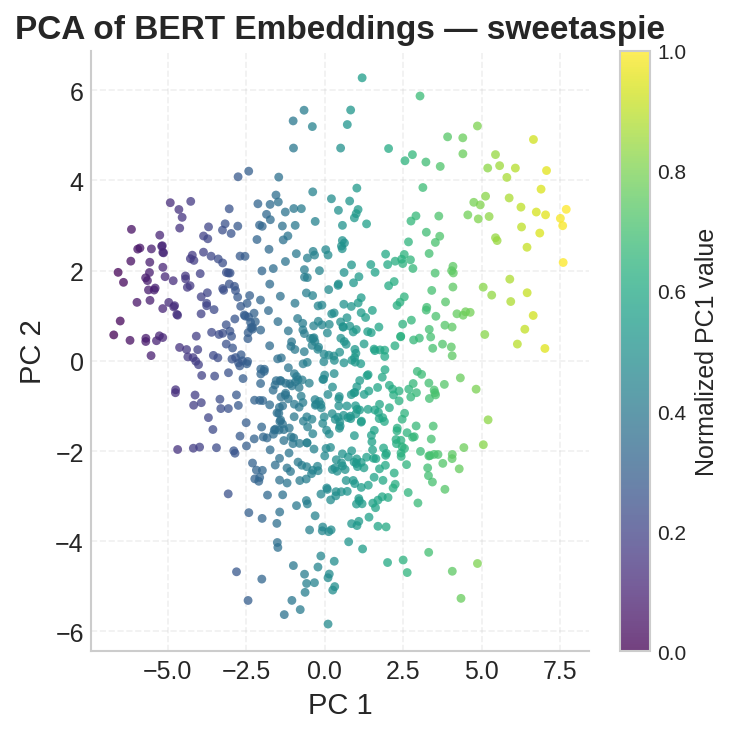

In [19]:
# PCA and visualization
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X2 = pca.fit_transform(embeddings)

norm = (X2[:,0] - X2[:,0].min()) / (X2[:,0].max() - X2[:,0].min())

plt.figure(figsize=(5,5), dpi=150)
plt.style.use("seaborn-v0_8-whitegrid")

# Scatter plot with transparency + colormap
plt.scatter(
    X2[:,0], X2[:,1],
    c=norm, cmap="viridis",     
    s=18,                      
    alpha=0.75,                
    edgecolor="none"
)

plt.title(f"PCA of BERT Embeddings — {second_id}", fontsize=16, fontweight="bold")
plt.xlabel("PC 1", fontsize=14)
plt.ylabel("PC 2", fontsize=14)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.grid(True, linestyle="--", alpha=0.3)

for spine in ["top", "right"]:
    plt.gca().spines[spine].set_visible(False)

cbar = plt.colorbar()
cbar.set_label("Normalized PC1 value", fontsize=12)

plt.tight_layout()
plt.show()


# Data Preprocessing

In [6]:
from preprocessing import downsample_word_vectors, make_delayed

BASE_DIR = Path("/ocean/projects/mth250011p/shared/215a/final_project")
TEXT_PATH = BASE_DIR / "data" / "raw_text.pkl"

BOLD_BASE = BASE_DIR / "data"
SUBJECT_DIRS = {
    2: BOLD_BASE / "subject2",
    3: BOLD_BASE / "subject3",
}

BERT_EMB_PATH = Path.cwd() / "embeddings" / "bert_base_uncased_word_embeddings.pkl"

# DataSequence (wordseqs)
with open(TEXT_PATH, "rb") as f:
    wordseqs = pickle.load(f)   # dict: story_id -> DataSequence

print("wordseqs stories:", list(wordseqs.keys())[:5])

# BERT embedding
with open(BERT_EMB_PATH, "rb") as f:
    bert_emb = pickle.load(f)   # dict: story_id -> {..., "embeddings": (T,768)}

print("bert_emb stories:", list(bert_emb.keys())[:5])

# check story id
stories = sorted(set(wordseqs.keys()) & set(bert_emb.keys()))
print("num stories:", len(stories))
stories[:5]

wordseqs stories: ['sweetaspie', 'thatthingonmyarm', 'tildeath', 'indianapolis', 'lawsthatchokecreativity']
bert_emb stories: ['sweetaspie', 'thatthingonmyarm', 'tildeath', 'indianapolis', 'lawsthatchokecreativity']
num stories: 109


['adollshouse',
 'adventuresinsayingyes',
 'afatherscover',
 'afearstrippedbare',
 'againstthewind']

## downsample from embeddings

In [7]:
# downsample_word_vectors
word_vectors = {}
for sid in stories:
    embs = bert_emb[sid]["embeddings"]   # (num_words, 768)
    word_vectors[sid] = embs.astype("float32")

downsampled_semanticseqs = downsample_word_vectors(
    stories=stories,
    word_vectors=word_vectors,
    wordseqs=wordseqs
)

## trim and delay

In [10]:
OUT_DIR = Path("/ocean/projects/mth250011p/ypan14/preprocessing")
OUT_DIR.mkdir(parents=True, exist_ok=True)

def preprocess_subject_streaming(subject_id, delays=None):
    subj_dir = SUBJECT_DIRS[subject_id]
    assert subj_dir.is_dir(), f"{subj_dir} does not exist"

    missing_stories = []

    for sid in stories:
        ds = wordseqs[sid]
        tr_times = ds.tr_times
        stim_tr  = downsampled_semanticseqs[sid]

        assert stim_tr.shape[0] == len(tr_times)

        bold_path = subj_dir / f"{sid}.npy"
        if not bold_path.is_file():
            print(f"[WARN] Subject {subject_id}: missing BOLD for story '{sid}', skipping.")
            missing_stories.append(sid)
            continue

        bold = np.load(bold_path)

        n_stim = stim_tr.shape[0]
        n_bold = bold.shape[0]

        if n_stim < n_bold:
            print(f"[WARN] {sid}: stim shorter than bold, skipping.")
            missing_stories.append(sid)
            continue

        # TR trimming to match BOLD length
        diff = n_stim - n_bold
        drop_start = diff // 3 if diff > 0 else 0
        drop_end = diff - drop_start if diff > 0 else 0

        stim_trim = stim_tr[drop_start : n_stim - drop_end]

        if stim_trim.shape[0] != n_bold:
            print(f"[WARN] {sid}: mismatch after trim, skipping.")
            missing_stories.append(sid)
            continue

        # delay
        if delays is None:
            raise ValueError("delays must be provided if only X_delayed is saved.")

        X_delayed = make_delayed(stim_trim, delays=delays)
        X_delayed = X_delayed.astype("float32")

        bold = bold.astype("float32")

        result = {
            "X_delayed": X_delayed,   # (N, 768 * len(delays))
            "bold": bold,             # (N, n_vox)
        }

        out_file = OUT_DIR / f"subject{subject_id}_{sid}_Xdelayed.pkl"
        with open(out_file, "wb") as f:
            pickle.dump(result, f)

        print(
            f"[SAVE] Subject {subject_id}, story {sid}: "
            f"X_delayed {X_delayed.shape}, bold {bold.shape}, saved"
        )

        del bold, stim_trim, X_delayed, result

    if missing_stories:
        print(f"\n[INFO] Subject {subject_id} skipped stories:")
        for s in missing_stories:
            print("  -", s)
    else:
        print(f"\n[INFO] Subject {subject_id}: all stories processed.")


In [11]:
delays = [1,2,3,4]
preprocess_subject_streaming(2, delays=delays)
preprocess_subject_streaming(3, delays=delays)

[SAVE] Subject 2, story adollshouse: X_delayed (241, 3072), bold (241, 94251), saved
[SAVE] Subject 2, story adventuresinsayingyes: X_delayed (391, 3072), bold (391, 94251), saved
[SAVE] Subject 2, story afatherscover: X_delayed (312, 3072), bold (312, 94251), saved
[SAVE] Subject 2, story afearstrippedbare: X_delayed (427, 3072), bold (427, 94251), saved
[SAVE] Subject 2, story againstthewind: X_delayed (170, 3072), bold (170, 94251), saved
[SAVE] Subject 2, story alternateithicatom: X_delayed (343, 3072), bold (343, 94251), saved
[SAVE] Subject 2, story avatar: X_delayed (367, 3072), bold (367, 94251), saved
[SAVE] Subject 2, story backsideofthestorm: X_delayed (345, 3072), bold (345, 94251), saved
[SAVE] Subject 2, story becomingindian: X_delayed (388, 3072), bold (388, 94251), saved
[SAVE] Subject 2, story beneaththemushroomcloud: X_delayed (342, 3072), bold (342, 94251), saved
[SAVE] Subject 2, story birthofanation: X_delayed (264, 3072), bold (264, 94251), saved
[SAVE] Subject 2,